In [34]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import math
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from mlxtend.classifier import StackingClassifier

In [2]:
# 환경 변수에서 데이터셋 경로 로드
config = dotenv_values('.env')
dataset_path = config['DATASET_PATH']
titanic_path = config['TITANIC_DATA']
fpath = dataset_path + titanic_path

# 타이타닉 데이터셋 로드
df = pd.read_csv(fpath, encoding='utf-8')
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [3]:
# 데이터셋 정보 출력
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# 불필요한 열 제거 및 결측치 제거
print('df_length:', len(df))
df_droped = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'])
df_droped = df_droped.dropna().reset_index(drop=True)
print('df_droped_length:', len(df_droped))
print(df_droped.describe())

df_length: 891
df_droped_length: 714
         Survived      Pclass         Age       SibSp       Parch        Fare
count  714.000000  714.000000  714.000000  714.000000  714.000000  714.000000
mean     0.406162    2.236695   29.699118    0.512605    0.431373   34.694514
std      0.491460    0.838250   14.526497    0.929783    0.853289   52.918930
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    1.000000   20.125000    0.000000    0.000000    8.050000
50%      0.000000    2.000000   28.000000    0.000000    0.000000   15.741700
75%      1.000000    3.000000   38.000000    1.000000    1.000000   33.375000
max      1.000000    3.000000   80.000000    5.000000    6.000000  512.329200


In [5]:
# 값을 범위에 따라 분류하는 함수 정의
def df_value_to_range(df, value_col, range_col, item_range):
    """
    지정된 열의 값을 범위에 따라 다른 열에 분류하여 저장함.
    
    Args:
        df: DataFrame
        value_col: 값을 기준으로 할 열 이름
        range_col: 분류된 범위를 저장할 열 이름
        item_range: (최소값, 최대값, 범위 이름)의 튜플 리스트
    
    Returns:
        DataFrame: 범위가 분류된 DataFrame
    """

    df_copy = df.copy()
    for (item_min, item_max, range_name) in item_range:
        condition = None
        if item_min != None and item_max != None:
            condition = (df_copy[value_col] >= item_min) & (df_copy[value_col] < item_max)
        
        df_copy.loc[condition, range_col] = range_name
    
    return df_copy

In [6]:
# 요금(Fare)을 범위에 따라 분류(도수 구간 작성)
df_prob = df_droped.copy()
df_prob['pay'] = 0
pay_range = [
    [0, 50, 50],
    [50, 100, 100],
    [100, 150, 150],
    [150, 200, 200],
    [200, 300, 300],
    [300, 400, 400],
    [400, 500, 500],
    [500, 600, 600],
]
df_prob = df_value_to_range(df_prob, 'Fare', 'pay', pay_range)

print(df_prob[['Fare','pay']].head())
df_prob = df_prob.drop(columns=['Fare',])

      Fare  pay
0   7.2500   50
1  71.2833  100
2   7.9250   50
3  53.1000  100
4   8.0500   50


In [7]:
# 나이(Age)를 범위에 따라 분류(도수 구간 작성)
df_prob['Gen'] = 0
gen_range = [
    [0, 10, 0],
    [10, 20, 10],
    [20, 30, 20],
    [30, 40, 30],
    [40, 50, 40],
    [50, 60, 50],
    [60, 70, 60],
    [70, 80, 70],
    [80, 90, 80],
]

df_prob = df_value_to_range(df_prob, 'Age', 'Gen', gen_range)

print(df_prob[['Age', 'Gen']].head())
df_prob = df_prob.drop(columns=['Age',])

    Age  Gen
0  22.0   20
1  38.0   30
2  26.0   20
3  35.0   30
4  35.0   30


In [8]:
# 특성(x)과 타겟(y) 분리 및 훈련/테스트 데이터셋 분할
x_sample = df_prob.drop(columns=['Survived'])
y_sample = df_prob['Survived']

(probX_train, probX_test, proby_train, proby_test) = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

In [9]:
# 훈련 데이터셋에 대한 통계 계산
train_df_prob = pd.concat([probX_train, proby_train], axis=1)
train_df_prob.head()

,Pclass,Sex,SibSp,Parch,pay,Gen,Survived
488,2,male,0,0,50,20,0
491,3,male,1,1,50,20,1
55,2,male,0,0,100,20,0
272,1,male,0,0,50,40,0
408,1,female,1,0,100,50,1


In [10]:
# 각 그룹별 개수 및 생존자 수 계산
train_df_prob['cnt'] = train_df_prob.drop(columns='Survived').groupby(['Pclass', 'Sex', 'Gen', 'SibSp', 'Parch','pay'])['pay'].transform('count')
train_df_prob['sur_cnt'] = train_df_prob.groupby(['Pclass', 'Sex', 'Gen', 'SibSp', 'Parch','pay'])['Survived'].transform('sum')

In [11]:
# 생존 확률 계산
train_df_prob['prob'] = train_df_prob['sur_cnt']/train_df_prob['cnt']
print(train_df_prob.head())
print(train_df_prob.columns)

     Pclass     Sex  SibSp  Parch  pay  Gen  Survived  cnt  sur_cnt      prob
488       2    male      0      0   50   20         0   14        0  0.000000
491       3    male      1      1   50   20         1    1        1  1.000000
55        2    male      0      0  100   20         0    1        0  0.000000
272       1    male      0      0   50   40         0   11        3  0.272727
408       1  female      1      0  100   50         1    3        3  1.000000
Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'pay', 'Gen', 'Survived', 'cnt',
       'sur_cnt', 'prob'],
      dtype='object')


In [12]:
# 테스트 데이터셋에 훈련 데이터셋의 통계 병합
prob_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'pay', 'Gen']
train_df_dupl = train_df_prob.drop_duplicates(subset=prob_cols)
test_df_prob = pd.merge(probX_test, train_df_dupl, on=prob_cols, how='left')
print()
print(test_df_prob.head(), '\n')
print(test_df_prob.info(), '\n')
print('probX_test_length:', probX_test.shape)
print('test_df_prob_length:', test_df_prob.shape)


   Pclass     Sex  SibSp  Parch  pay  Gen  Survived   cnt  sur_cnt      prob
0       3  female      0      0   50   20       0.0  12.0      6.0  0.500000
1       3  female      0      0   50   60       NaN   NaN      NaN       NaN
2       3  female      1      3   50   40       NaN   NaN      NaN       NaN
3       2    male      0      0   50   30       0.0  14.0      1.0  0.071429
4       3    male      0      0   50   30       0.0  29.0      5.0  0.172414 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    143 non-null    int64  
 1   Sex       143 non-null    object 
 2   SibSp     143 non-null    int64  
 3   Parch     143 non-null    int64  
 4   pay       143 non-null    int64  
 5   Gen       143 non-null    int64  
 6   Survived  106 non-null    float64
 7   cnt       106 non-null    float64
 8   sur_cnt   106 non-null    float64
 

In [13]:
# 테스트 데이터셋의 결측치 처리
test_df_prob[['Survived', 'cnt', 'sur_cnt', 'prob']] = test_df_prob[['Survived', 'cnt', 'sur_cnt', 'prob']].fillna(0)
test_df_prob[['Survived', 'cnt', 'sur_cnt']] = test_df_prob[['Survived', 'cnt', 'sur_cnt']].astype(int)
print(test_df_prob.head(), '\n')
print(test_df_prob.info(), '\n')
print('test_df_prob_length:', test_df_prob.shape)
print('proby_test_length:', proby_test.shape)

   Pclass     Sex  SibSp  Parch  pay  Gen  Survived  cnt  sur_cnt      prob
0       3  female      0      0   50   20         0   12        6  0.500000
1       3  female      0      0   50   60         0    0        0  0.000000
2       3  female      1      3   50   40         0    0        0  0.000000
3       2    male      0      0   50   30         0   14        1  0.071429
4       3    male      0      0   50   30         0   29        5  0.172414 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    143 non-null    int64  
 1   Sex       143 non-null    object 
 2   SibSp     143 non-null    int64  
 3   Parch     143 non-null    int64  
 4   pay       143 non-null    int64  
 5   Gen       143 non-null    int64  
 6   Survived  143 non-null    int32  
 7   cnt       143 non-null    int32  
 8   sur_cnt   143 non-null    int32  
 9   pro

In [14]:
# 모델 학습을 위한 데이터셋 준비
df_model = df_droped.copy()
df_model['Sexclass'] = 0
df_model.loc[df_model['Sex']=='male', 'Sexclass'] = 1
df_model = df_model.drop(columns='Sex')
df_model.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sexclass
Survived,1.000000,-0.359653,-0.077221,-0.017358,0.093317,0.268189,-0.538826
Pclass,-0.359653,1.000000,-0.369226,0.067247,0.025683,-0.554182,0.155460
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254
SibSp,-0.017358,0.067247,-0.308247,1.000000,0.383820,0.138329,-0.103950
Parch,0.093317,0.025683,-0.189119,0.383820,1.000000,0.205119,-0.246972
Fare,0.268189,-0.554182,0.096067,0.138329,0.205119,1.000000,-0.184994
Sexclass,-0.538826,0.155460,0.093254,-0.103950,-0.246972,-0.184994,1.000000


<Figure size 640x480 with 0 Axes>

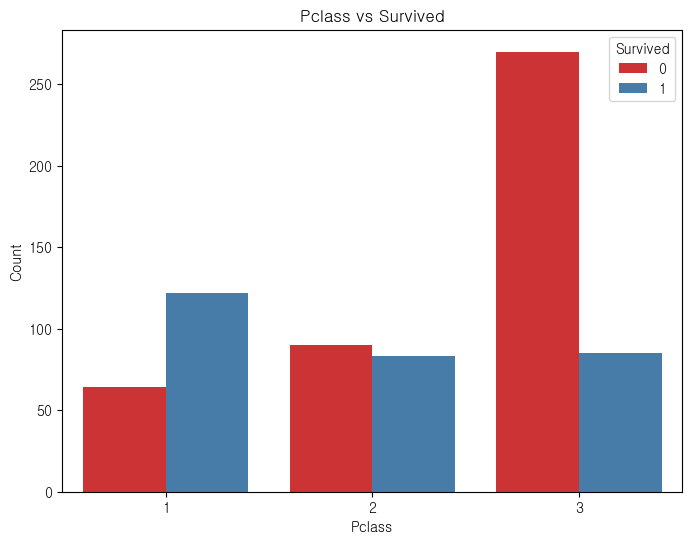

<Figure size 640x480 with 0 Axes>

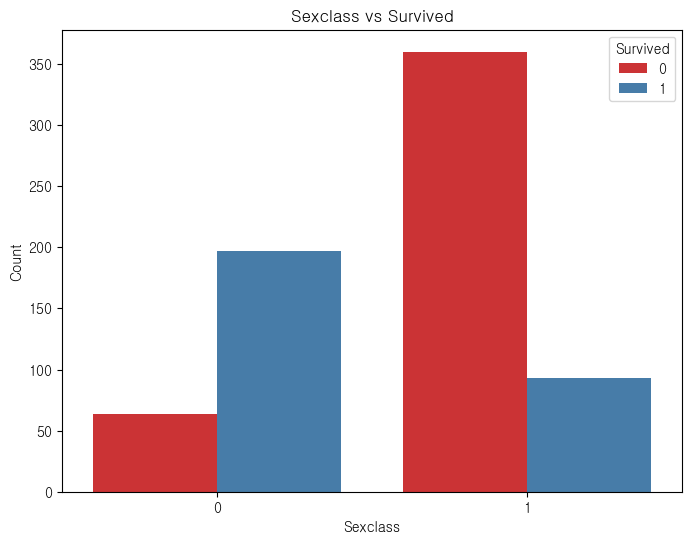

In [15]:
# 범주형 특성에 대한 생존 여부 시각화
cols = ['Pclass', 'Sexclass']
for col in cols:
    plt.figure()
    plt.figure(figsize=(8, 6))
    data = df_model.groupby([col, 'Survived']).size().reset_index(name='Count')
    
    # 막대그래프 생성
    sns.barplot(data=data, x=col, y='Count', hue='Survived', palette='Set1')
    plt.title(f'{col} vs Survived')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Survived')
    plt.savefig(col + '.png')
    plt.show()

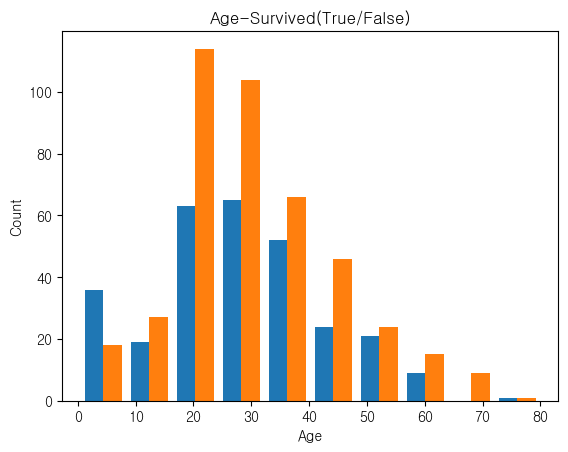

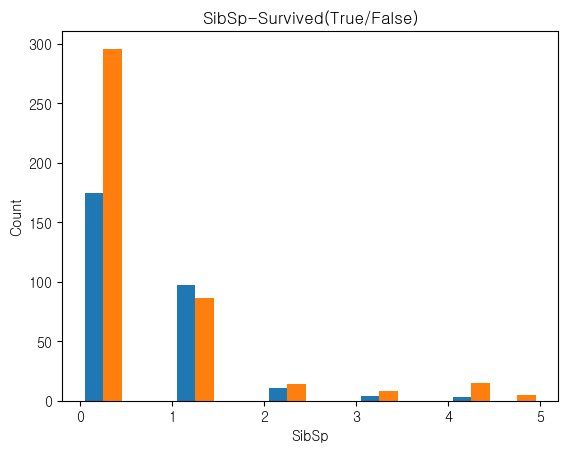

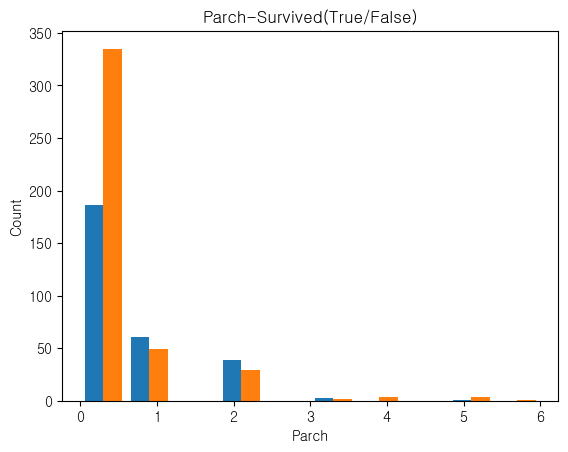

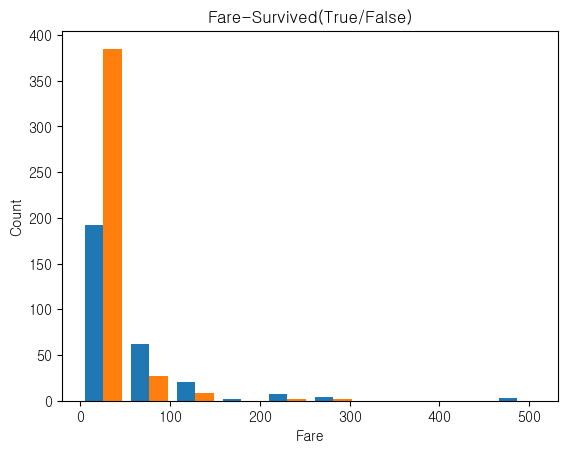

In [16]:
# 연속형 특성에 대한 생존 여부 시각화
cols = ['Age', 'SibSp', 'Parch', 'Fare']
for col in cols:
    plt.figure()
    df_surv = df_model.loc[df_model['Survived']==1, col]
    df_not_surv = df_model.loc[df_model['Survived']==0, col]
    plt.hist((df_surv, df_not_surv), histtype='bar')
    plt.title(f'{col}-Survived(True/False)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.savefig(col + '.png')
    plt.show()

In [17]:
# 특성(x)과 타겟(y) 분리 및 훈련/테스트 데이터셋 분할
x_sample = df_model.drop(columns=['Survived'])
y_sample = df_model['Survived']
(X_train, X_test, y_train, y_test) = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

In [18]:
# 데이터 표준화(정규화, 스케일링)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# 분류 모델 학습 및 평가 함수 정의
def classifier_model(data_set, model_name, model, prob, report_txt):
    """
    분류 모델을 학습하고 평가.
    
    Args:
        data_set: (X_train, y_train, y_test) 튜플
        model_name: 모델 이름
        model: 학습할 모델 객체
        prob: 확률 예측 방법 ('predict_proba', 'decision_function', None)
        report_txt: 리포트 문자열
    
    Returns:
        (report_txt, model): 리포트 문자열과 학습된 모델
    """

    (X_train, y_train, y_test) = data_set
    time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(model_name, "learning", time_now)
    report_txt += model_name + '\n'

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = model.predict(X_test)
    y_prob = ''
    if prob == 'predict_proba':
        y_prob = model.predict_proba(X_test)[:, 1]  # 확률 예측

    elif prob == 'decision_function':
        y_prob = model.decision_function(X_test)
    
    # 성능 지표 출력
    report = classification_report(y_test, y_pred)
    roc_auc = ''
    if prob != None:
        roc_auc = "ROC-AUC Score:" + str(roc_auc_score(y_test, y_prob))
    model_report = str(report) + '\n' + str(roc_auc) + '\n\n\n'
    report_txt += model_report

    return (report_txt, model)

In [20]:
# 여러 분류 모델을 학습하고 평가하는 함수 정의
def loof_classifier(data_set, model_list, report_txt):
    """
    여러 분류 모델을 학습하고 평가합니다.
    
    Args:
        data_set: (X_train, y_train, y_test) 튜플
        model_list: [(model_name, model, prob)]의 리스트
        report_txt: 리포트 문자열
    
    Returns:
        report_txt: 리포트 문자열
    """

    for model_info in model_list:
        (model_name, model, prob) = model_info
        (report_txt, model) = classifier_model(data_set, model_name, model, prob, report_txt)

    return report_txt

In [21]:
# 사용할 모델 리스트 정의
model_list = [
    ['LogisticRegression', LogisticRegression(), 'predict_proba'],
    ['GaussianNB', GaussianNB(), 'predict_proba'],
    ['KNeighborsClassifier', KNeighborsClassifier(), 'predict_proba'],
    ['LinearSVC', LinearSVC(), 'decision_function'],
    ['SVC Linear', SVC(kernel='linear'), 'decision_function'],
    ['SVC', SVC(), 'decision_function'],
    ['DecisionTreeClassifier', DecisionTreeClassifier(), 'predict_proba'],
    ['RandomForestClassifier', RandomForestClassifier(), 'predict_proba'],
    ['AdaBoostClassifier', AdaBoostClassifier(), 'predict_proba'],
    ['XGBClassifier', XGBClassifier(), 'predict_proba'],
    # ['LGBMClassifier', LGBMClassifier(), 'predict_proba'],
    # ['CatBoostClassifier', CatBoostClassifier(), 'predict_proba'],
]

In [22]:
# 모델 학습 및 평가 결과 저장
report_txt = ''
data_set = (X_train, y_train, y_test)
report_txt = loof_classifier(data_set, model_list, report_txt)
with open('model_report.txt', mode='w', encoding='utf-8-sig') as f:
    f.write(report_txt)

LogisticRegression learning 2025-02-02 19:10:41
GaussianNB learning 2025-02-02 19:10:41
KNeighborsClassifier learning 2025-02-02 19:10:41
LinearSVC learning 2025-02-02 19:10:41
SVC Linear learning 2025-02-02 19:10:41
SVC learning 2025-02-02 19:10:41
DecisionTreeClassifier learning 2025-02-02 19:10:42
RandomForestClassifier learning 2025-02-02 19:10:42
AdaBoostClassifier learning 2025-02-02 19:10:42
XGBClassifier learning 2025-02-02 19:10:42


c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [23]:
# 기술 통계 확률 예측
# 예측 및 평가
y_pred = test_df_prob['Survived']
y_prob = test_df_prob['prob']
y_test = proby_test

# 성능 지표 출력
report = classification_report(y_test, y_pred)
roc_auc = "ROC-AUC Score:" + str(roc_auc_score(y_test, y_prob))
model_report = str(report) + '\n' + str(roc_auc) + '\n\n'
print('기술 통계 확률 예측')
print(model_report)

기술 통계 확률 예측
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        85
           1       0.73      0.47      0.57        58

    accuracy                           0.71       143
   macro avg       0.72      0.67      0.68       143
weighted avg       0.72      0.71      0.70       143

ROC-AUC Score:0.6377281947261664




In [24]:
# 기술 통계 결측치 보완: 성별 평균 사용
prob_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'pay', 'Gen']
train_df_dupl = train_df_prob.drop_duplicates(subset=prob_cols)
test_df_prob = pd.merge(probX_test, train_df_dupl, on=prob_cols, how='left')

slice_cols = ['Survived', 'cnt', 'sur_cnt', 'prob']
test_df_sex = test_df_prob['Sex']
test_df_mean_m = test_df_prob.loc[test_df_sex=='male', slice_cols].dropna().mean()
test_df_mean_f = test_df_prob.loc[test_df_sex=='female', slice_cols].dropna().mean()

test_df_prob.loc[
    test_df_sex=='male', slice_cols
] = test_df_prob.loc[
    test_df_sex=='male', slice_cols].fillna(test_df_mean_m)

test_df_prob.loc[
    test_df_sex=='female', slice_cols
] = test_df_prob.loc[
    test_df_sex=='female', slice_cols].fillna(test_df_mean_f)

# 예측값 이진 변환
test_df_prob.loc[test_df_prob['Survived'] >= 0.5 ] = 1
test_df_prob.loc[test_df_prob['Survived'] < 0.5 ] = 0
int_cols = ['Survived', 'cnt', 'sur_cnt']
test_df_prob[int_cols] = test_df_prob[int_cols].astype(int)

In [25]:
# 기술 통계 확률 예측: 결측치 보완 후
# 예측 및 평가
y_pred = test_df_prob['Survived']
y_prob = test_df_prob['prob']
y_test = proby_test

# 성능 지표 출력
report = classification_report(y_test, y_pred)
roc_auc = "ROC-AUC Score:" + str(roc_auc_score(y_test, y_prob))
model_report = str(report) + '\n' + str(roc_auc) + '\n\n'
print('기술 통계 확률 예측: 결측치 보완 후')
print(model_report)

기술 통계 확률 예측: 결측치 보완 후
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        85
           1       0.75      0.71      0.73        58

    accuracy                           0.78       143
   macro avg       0.78      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143

ROC-AUC Score:0.7710953346855984




In [26]:
# RandomizedSearchCV를 수행하는 함수 정의
def random_srch(model, param_dict):
    """
    RandomizedSearchCV를 수행.
    
    Args:
        model: 모델 객체
        param_dict: 하이퍼파라미터 딕셔너리
    
    Returns:
        RandomizedSearchCV 객체
    """

    random_search = RandomizedSearchCV(
        model, 
        param_distributions=param_dict, 
        n_iter=10,
        cv=5, 
        scoring='accuracy', 
        random_state=42,
        n_jobs=-2
    )

    return random_search

In [27]:
# GridSearchCV를 수행하는 함수 정의
def grid_srch(model, param_dict, random_search=None, grid_rate=0.5, grid_num=5):
    """
    GridSearchCV를 수행.
    
    Args:
        model: 모델 객체
        param_dict: 하이퍼파라미터 딕셔너리
        random_search: RandomizedSearchCV 객체 (선택 사항)
        grid_rate: 그리드 탐색 범위 비율 (기본값: 0.5)
        grid_num: 그리드 탐색 개수 (기본값: 5)
    
    Returns:
        GridSearchCV 객체
    """
    
    if random_search != None:
        key_list = param_dict.keys()

        grid_param_dict = random_search.best_params_.copy()
        for key in key_list:
            best_param = grid_param_dict[key]

            best_range = best_param
            try:
                add_down = math.floor(best_param * grid_rate)
                add_up = math.ceil(best_param * grid_rate)
                best_range = np.linspace(add_down, best_param + add_up, grid_num)
                if type(best_param) in [int, np.int8, np.int16, np.int32, np.int64, np.int128]:
                    best_range = best_range.astype(int)
                
            except Exception as e:
                best_range = best_param

            grid_param_dict[key] = best_range

    # 그리드 서치 수행 (세밀한 탐색)
    grid_search = GridSearchCV(
        model, 
        param_grid=param_dict, 
        cv=5,
        scoring='accuracy', 
        n_jobs=-2
    )
    
    return grid_search

In [28]:
# 하이퍼파라미터 튜닝을 포함하여 모델 학습 및 평가 함수 정의
def hyper_classifier(data_set, model_list, report_txt, grid_rate=0.5, grid_num=5):
    """
    하이퍼파라미터 튜닝을 포함하여 모델을 학습하고 평가.
    
    Args:
        data_set: (X_train, y_train, y_test) 튜플
        model_list: [(model_name, model, prob, param_dict)]의 리스트
        report_txt: 리포트 문자열
        grid_rate: 그리드 탐색 범위 비율 (기본값: 0.5)
        grid_num: 그리드 탐색 개수 (기본값: 5)
    
    Returns:
        report_txt: 리포트 문자열
    """

    (X_train, y_train, y_test) = data_set.copy()
    fornum = 0
    for model_info in model_list:
        (model_name, model, prob, param_dict) = model_info
        time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(model_name, "start", time_now)
        
        if param_dict == None:
            pass

        else:
            random_search = random_srch(model, param_dict)
            random_search.fit(X_train, y_train)
            grid_search = grid_srch(model, param_dict, random_search, grid_rate, grid_num)
            model = grid_search

        (report_txt, model) = classifier_model(data_set, model_name, model, prob, report_txt)
        if param_dict != None:
            grid_params_str = str(model.best_params_)
            report_txt += '\n' + grid_params_str + '\n\n'
        fornum += 1

        time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(model_name, "end", time_now , '\n')

    return report_txt

In [29]:
# 각 모델에 대한 하이퍼파라미터 딕셔너리 정의
param_dict = {
    'LogisticRegression': {
        'C': np.logspace(-2, 1, 10),
        'penalty': ['none', 'l1', 'l2', 'elasticnet'],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
        'max_iter': np.logspace(2, 3, 10).astype(int),
    },
    'GaussianNB': None,
    'KNeighborsClassifier': {
        'n_neighbors': np.linspace(1, 20, 20).astype(int),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': np.linspace(20, 40, 21).astype(int),
        'p': [1, 2],
    },
    'LinearSVC': {
        'C': np.logspace(-3, 3, 20),
        'penalty': ['l1', 'l2'],
        'loss': ['hinge', 'squared_hinge'],
        'dual': [True, False],
        'tol': np.logspace(-4, 2, 10),
        'class_weight': ['balanced', None],
    },
    'SVC': {
        'C': np.logspace(-2, 1, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': np.logspace(-3, 0, 10),
        'tol': np.logspace(-4, 2, 10),
        'max_iter': np.linspace(-1, 10, 12).astype(int)
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': np.linspace(5, 100, 5).astype(int),
        'min_samples_split': np.linspace(2, 20, 5).astype(int),
        'min_samples_leaf': np.linspace(1, 5, 5).astype(int),
        'max_features': ['sqrt', 'log2', None],
        'max_leaf_nodes': np.linspace(5, 100, 5).astype(int),
        'min_impurity_decrease': np.linspace(0.0, 10.0, 5),
    },
    'RandomForestClassifier': {
        'n_estimators': np.linspace(100, 1000, 5).astype(int),
        'criterion': ['gini', 'entropy'],
        'max_depth': np.linspace(10, 100, 5).astype(int),
        'min_samples_split': np.linspace(2, 20, 5).astype(int),
        'min_samples_leaf': np.linspace(1, 5, 5).astype(int),
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False],
    },
    'AdaBoostClassifier': {
        'n_estimators': np.linspace(50, 500, 5).astype(int),
        'learning_rate': np.logspace(-2, 0, 5),
        'algorithm': ['SAMME.R', 'SAMME'],
    },
    'XGBClassifier': {
        'n_estimators': np.linspace(50, 1000, 5).astype(int),
        'max_depth': np.linspace(3, 10, 5).astype(int),
        'learning_rate': np.linspace(0.1, 0.3, 3),
        'subsample': np.linspace(0.5, 1.0, 5),
        'colsample_bytree': np.linspace(0.3, 1.0, 5),
        'gamma': np.linspace(0, 5.0, 5),
    },
    'LGBMClassifier': {
        'n_estimators': np.linspace(100, 500, 5).astype(int),
        'max_depth': np.linspace(5, 10, 5).astype(int),
        'learning_rate': np.linspace(0.1, 0.3, 3),
        'num_leaves': np.linspace(5, 50, 5).astype(int),
        'min_data_in_leaf': np.linspace(10, 50, 5).astype(int),
        'feature_fraction': np.linspace(0.6, 1.0, 3),
        'bagging_fraction': np.linspace(0.5, 1.0, 3),
        'bagging_freq': np.linspace(1, 100, 5).astype(int),
        'lambda_l1': np.linspace(0, 1, 5),
        'lambda_l2': np.linspace(0, 1, 5),
    },
    'CatBoostClassifier': {
        'iterations': np.linspace(100, 2000, 5).astype(int),
        'learning_rate': np.logspace(-2, -1, 5),
        'depth': np.linspace(4, 10, 5).astype(int),
        'l2_leaf_reg': np.linspace(1.0, 10.0, 5),
        'border_count': np.linspace(32, 255, 5).astype(int),
        'bagging_temperature': np.linspace(0, 1.0, 5),
    },
}

In [30]:
# 일반 머신러닝 모델 리스트
model_list = [
    ['LogisticRegression', LogisticRegression(), 'predict_proba', param_dict['LogisticRegression']],
    ['GaussianNB', GaussianNB(), 'predict_proba', param_dict['GaussianNB']],
    ['KNeighborsClassifier', KNeighborsClassifier(), 'predict_proba', param_dict['KNeighborsClassifier']],
    ['LinearSVC', LinearSVC(), 'decision_function', param_dict['LinearSVC']],
    ['SVC', SVC(), 'decision_function', param_dict['SVC']],
    ['DecisionTreeClassifier', DecisionTreeClassifier(), 'predict_proba', param_dict['DecisionTreeClassifier']],
]

# 앙상블 모델 리스트
ensemble_list = [
    ['RandomForestClassifier', RandomForestClassifier(), 'predict_proba', param_dict['RandomForestClassifier']],
    ['AdaBoostClassifier', AdaBoostClassifier(), 'predict_proba', param_dict['AdaBoostClassifier']],
    ['XGBClassifier', XGBClassifier(), 'predict_proba', param_dict['XGBClassifier']],
    # ['LGBMClassifier', LGBMClassifier(), 'predict_proba', param_dict['LGBMClassifier']],
    # ['CatBoostClassifier', CatBoostClassifier(), 'predict_proba', param_dict['CatBoostClassifier']],
]

In [31]:
# 훈련/테스트 데이터셋 분할 및 표준화
x_sample = df_model.drop(columns=['Survived'])
y_sample = df_model['Survived']
(X_train, X_test, y_train, y_test) = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

# 데이터 표준화(정규화, 스케일링)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# 일반 머신러닝 모델 학습 및 평가 (하이퍼파라미터 튜닝 포함)
report_txt = ''
data_set = [X_train, y_train, y_test]
report_txt = hyper_classifier(data_set, model_list, report_txt)
with open('nomal_model_report_hyper.txt', mode='w', encoding='utf-8-sig') as f:
    f.write(report_txt)

LogisticRegression start 2025-02-02 19:10:42


c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aderb\AppData

LogisticRegression learning 2025-02-02 19:10:44


c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6500 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
878 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\b

LogisticRegression end 2025-02-02 19:10:46 

GaussianNB start 2025-02-02 19:10:46
GaussianNB learning 2025-02-02 19:10:46
GaussianNB end 2025-02-02 19:10:46 

KNeighborsClassifier start 2025-02-02 19:10:46
KNeighborsClassifier learning 2025-02-02 19:10:46
KNeighborsClassifier end 2025-02-02 19:11:02 

LinearSVC start 2025-02-02 19:11:02
LinearSVC learning 2025-02-02 19:11:02


c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aderb\AppDat

LinearSVC end 2025-02-02 19:11:07 

SVC start 2025-02-02 19:11:07
SVC learning 2025-02-02 19:11:07
SVC end 2025-02-02 19:14:45 

DecisionTreeClassifier start 2025-02-02 19:14:45
DecisionTreeClassifier learning 2025-02-02 19:14:45
DecisionTreeClassifier end 2025-02-02 19:15:04 



In [33]:
# 앙상블 모델 학습 및 평가 (하이퍼파라미터 튜닝 포함)
report_txt = ''
report_txt = hyper_classifier(data_set, ensemble_list, report_txt, 0.2, 3)
with open('ensemble_model_report_hyper.txt', mode='w', encoding='utf-8-sig') as f:
    f.write(report_txt)

RandomForestClassifier start 2025-02-02 19:15:04


c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py"

RandomForestClassifier learning 2025-02-02 19:15:05


c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
12500 fits failed out of a total of 37500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7664 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn

RandomForestClassifier end 2025-02-02 19:44:39 

AdaBoostClassifier start 2025-02-02 19:44:39


c:\Users\aderb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier learning 2025-02-02 19:44:42
AdaBoostClassifier end 2025-02-02 19:44:54 

XGBClassifier start 2025-02-02 19:44:54
XGBClassifier learning 2025-02-02 19:44:55
XGBClassifier end 2025-02-02 19:51:03 



In [35]:
# 스태킹 모델 정의 및 학습
# 최적의 파라미터로 모델 초기화(일반 머신러닝)
param_dict={'C': 0.46415888336127775, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
clf1 = LogisticRegression(**param_dict)

clf2 = GaussianNB()

param_dict={'C': 2.154434690031882, 'degree': 2, 'gamma': 0.21544346900318823, 'kernel': 'rbf', 'max_iter': -1, 'tol': 0.0001}
clf3 = SVC(**param_dict)


# 최적의 파라미터로 메타 모델 초기화(앙상블)
param_dict={'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 162}
meta_clf = AdaBoostClassifier(**param_dict)

In [45]:
# 스태킹 분류기 생성
sclf = StackingClassifier(
    classifiers=[clf1, clf2, clf3],
    meta_classifier=meta_clf,
    use_features_in_secondary=False
)

# 스태킹 모델 학습 및 평가
report_txt = ''
(report_txt, model) = classifier_model(data_set, 'StackingClassifier', sclf, 'predict_proba', report_txt)
with open('Stacking_model_report_hyper.txt', mode='w', encoding='utf-8-sig') as f:
    f.write(report_txt)

StackingClassifier learning 2025-02-02 21:54:31
